# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from prettytable import PrettyTable

In [ ]:
os.chdir(r'/content/drive/MyDrive/AppliedAI/self_case_study_1/ashrae_energy_prediction')

In [ ]:
building_metadata_df = pickle.load(open('data/input_data/building_metadata_df.pkl', 'rb'))
train_df = pickle.load(open('data/input_data/train_df.pkl', 'rb'))
# test_df = pickle.load(open('data/input_data/test_df.pkl', 'rb'))
weather_train_df = pickle.load(open('data/input_data/weather_train_df.pkl', 'rb'))
weather_test_df = pickle.load(open('data/input_data/weather_test_df.pkl', 'rb'))

# About Data
> ### train.csv
- building_id - unique id associated with 1449 buildings
- meter - unique meter id associated with 4 meter type {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}
- timestamp - hourly timestamp for year 2016
- meter_reading - Target reading to be predicted

> ### building_metadata.csv
- building_id - primary key for every building
- site_id - id of site which building belong to
- year_built - year when building was built
- floor_count - number of floors
- square_feet - floor area
- primary_use - category assigned to every building based on their primary use

> ### weather_test/train.csv
- site_id
- timestamp - hourly reading
- air_temperature - in degree celsius
- cloud_coverage 
- dew_temperature
- precip_depth_1_hr
- sea_level_pressure
- wind_direction - in degrees(0-360)
- wind_speed

> ### test.csv
- row_id - unique row id for every row
- building_id 
- meter 
- timestamp - hourly timestamp for 2 years (2017-2018)

# Building Metadata

In [ ]:
building_metadata_df.head(2)

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN


In [ ]:
print("Number of rows in building_metadata: ", building_metadata_df.shape[0])
print("Number of columns in building_metadata: ", building_metadata_df.shape[1])

Number of rows in building_metadata:  1449
Number of columns in building_metadata:  6


In [ ]:
columns = sorted(building_metadata_df.columns)
for col in columns:
    print(f"Number of unique values in {col}: ", building_metadata_df[f'{col}'].unique().shape[0])

Number of unique values in building_id:  1449
Number of unique values in floor_count:  19
Number of unique values in primary_use:  16
Number of unique values in site_id:  16
Number of unique values in square_feet:  1397
Number of unique values in year_built:  117


In [ ]:
print("Percentage of missing values:")
building_metadata_df.isna().sum() * 100 / building_metadata_df.shape[0]

Percentage of missing values:


site_id         0.000000
building_id     0.000000
primary_use     0.000000
square_feet     0.000000
year_built     53.416149
floor_count    75.500345
dtype: float64

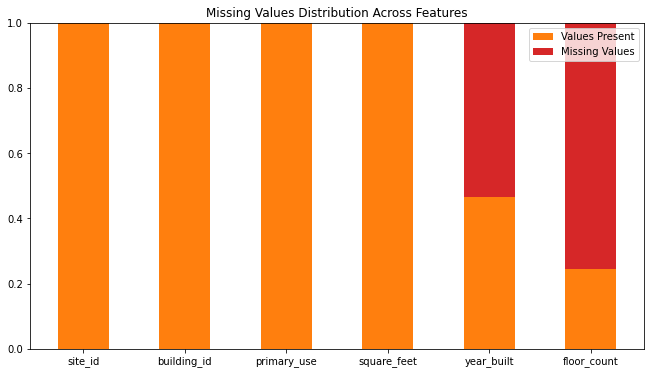

In [ ]:
labels = list(building_metadata_df.columns)
nan_values = (building_metadata_df.isna().sum() / building_metadata_df.shape[0]).values
non_nan_values = ((~building_metadata_df.isna()).sum() / building_metadata_df.shape[0]).values
fig, axs = plt.subplots(1,1,figsize=(11,6))
axs.bar(labels, non_nan_values, width = 0.5,  color='tab:orange', label='Values Present')
axs.bar(labels, nan_values, width = 0.5, color='tab:red', bottom=non_nan_values, label='Missing Values')
axs.legend()
axs.set_title("Missing Values Distribution Across Features")
plt.show()

Observation:
- More than 50% of building are not provided with year_built data
- Approx 75% of building do not have floor count, however since the min value of floor_count = 1 we can assume that buildings with only ground floors are filled as nan.
- We can impute nan as 0 or we can increase other values by 1 and impute nan floor_count as 1

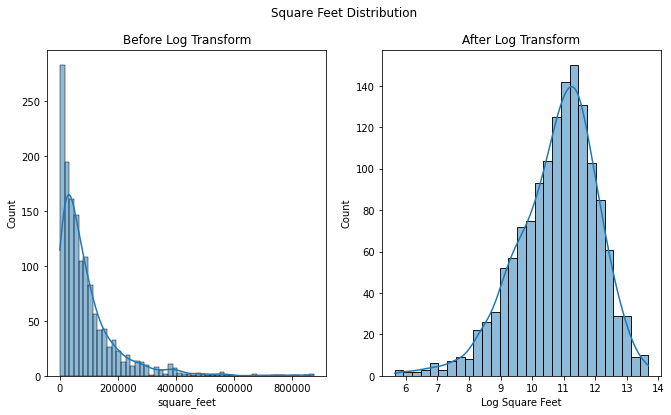

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(11,6))
sns.histplot(building_metadata_df['square_feet'], kde=True, ax=axs[0])
sns.histplot(np.log(building_metadata_df['square_feet']), kde=True, ax=axs[1])
axs[0].set_title("Before Log Transform")
axs[1].set_title("After Log Transform")
axs[1].set_xlabel("Log Square Feet")
plt.suptitle("Square Feet Distribution")
plt.show()

Observation:
- square_feet distribution right tailed
- taking log of square_feet converge values

In [ ]:
print("Overall Statistics:")
building_metadata_df.describe()

Overall Statistics:


,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957031,3.740845
std,5.003432,418.434583,110769.950997,31.054029,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


# train_df

In [ ]:
train_df.head(2)

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0


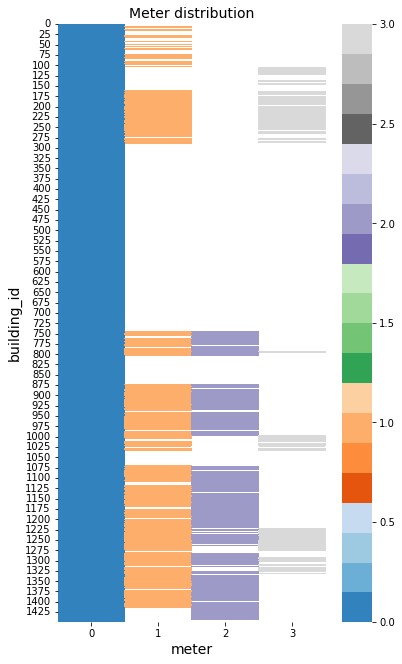

+-------+--------------------+
| Meter | Number of building |
+-------+--------------------+
|   0   |        1413        |
|   1   |        498         |
|   2   |        324         |
|   3   |        145         |
+-------+--------------------+


In [ ]:
#visualize meter distribution in building
temp = train_df[['building_id', 'meter']].drop_duplicates().pivot(index='building_id', columns='meter', values='meter')
plt.figure(figsize=(6,11))
sns.heatmap(temp, cmap='tab20c')
plt.title("Meter distribution", fontsize=14)
plt.xlabel('meter', fontsize=14)
plt.ylabel('building_id', fontsize=14)
plt.show()

x = PrettyTable()
x.field_names = ["Meter", "Number of building"]
x.add_rows(list((~temp.isna()).sum().items()))
print(x)

Observation:
- 59.36% (1413/2380) of building meter pair belong to meter 0 (electricity)
- 20.92% belong to meter 1 (chilled water)
- 13.61% belong to meter 2 (steam)
- 6.09 % belong to meter 3 (hot water)

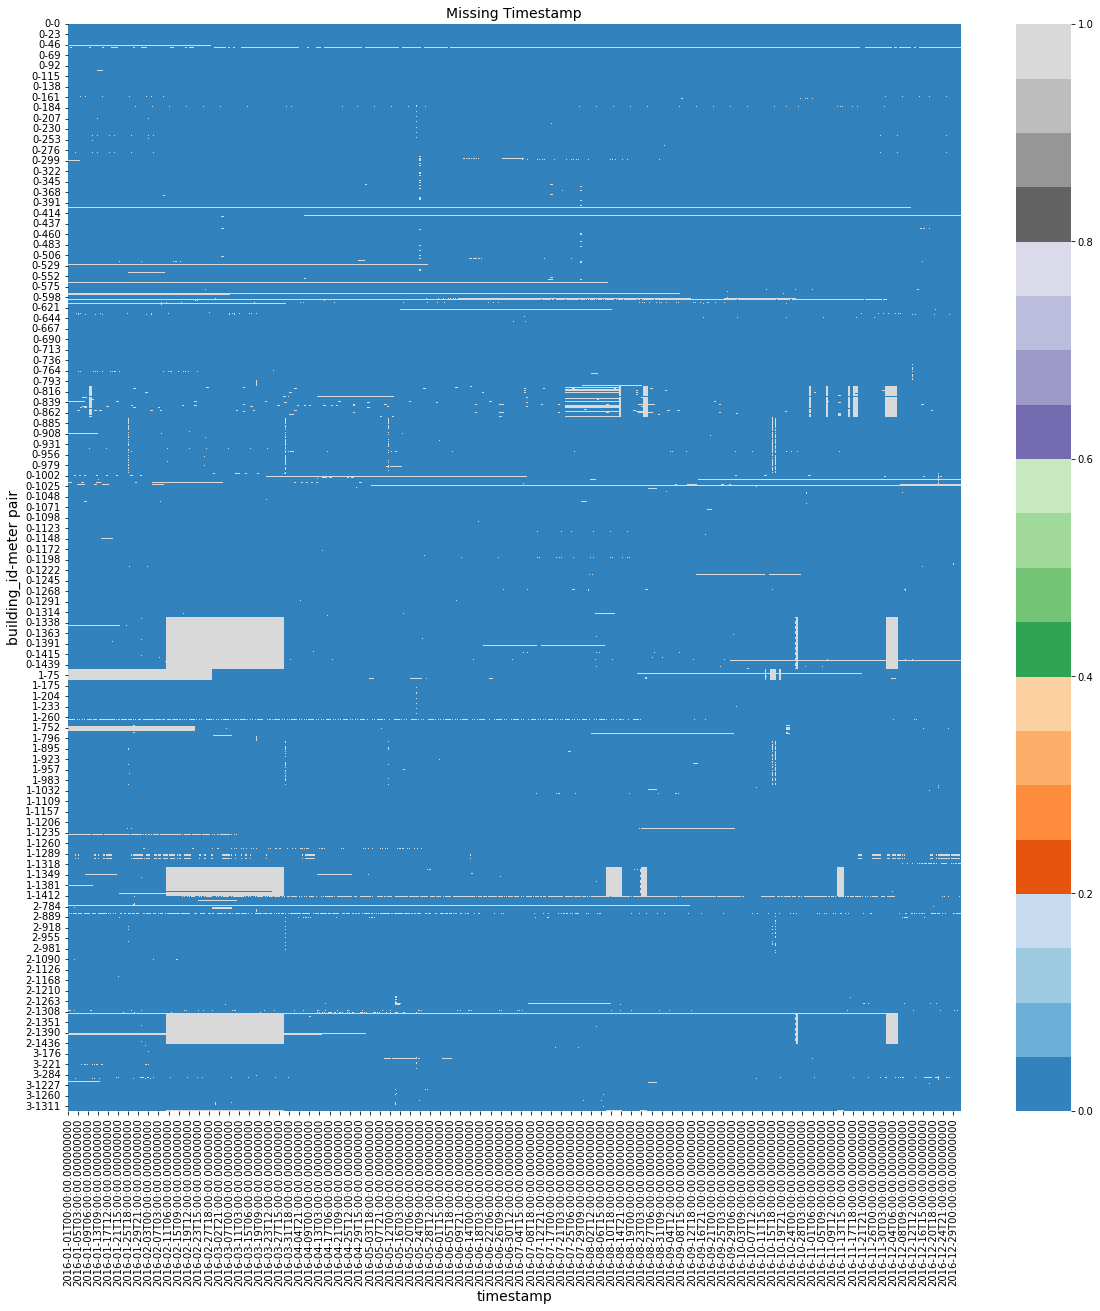

In [ ]:
# visualize missing timestamp for every building-meter pair
temp = train_df.pivot(index=['meter', 'building_id'], columns='timestamp',
                      values='meter_reading')
plt.figure(figsize=(20,20))
sns.heatmap(temp.isna(), cmap='tab20c')
plt.title("Missing Timestamp", fontsize=14)
plt.xlabel('timestamp', fontsize=14)
plt.ylabel('building_id-meter pair', fontsize=14)
plt.show()

# x = temp.T.isna().sum()/8784
# for i in range(0,101, 10):
#     print(f"Number of building-meter pair having missing timestamp >= {i:3}%: ", (x*100>=i).sum())

Observation:
- White/grey line indicate missing value for a particular timestamp
- We can observe long horizontal lines which are spread all over the year
- Thick white patch indicate anomaly at site level (Eg: building in range 1300-1400 belong to same site and they all show similar pattern in missing values)

In [ ]:
x = temp.isna().sum(axis=1)/8784
for i in range(0,101, 10):
    print(f"Number of building-meter pair having missing timestamp >= {i:3}%: ", (x*100>=i).sum())

Number of building-meter pair having missing timestamp >=   0%:  2380
Number of building-meter pair having missing timestamp >=  10%:  365
Number of building-meter pair having missing timestamp >=  20%:  61
Number of building-meter pair having missing timestamp >=  30%:  41
Number of building-meter pair having missing timestamp >=  40%:  26
Number of building-meter pair having missing timestamp >=  50%:  18
Number of building-meter pair having missing timestamp >=  60%:  17
Number of building-meter pair having missing timestamp >=  70%:  7
Number of building-meter pair having missing timestamp >=  80%:  5
Number of building-meter pair having missing timestamp >=  90%:  2
Number of building-meter pair having missing timestamp >= 100%:  0


In [ ]:
print("Building meter pair with more than 40% missing timestamp values")
less_reading_building_meter = x.index[np.where(x>=0.4)].tolist()
print(less_reading_building_meter)

Building meter pair with more than 40% missing timestamp values
[(0, 29), (0, 53), (0, 403), (0, 420), (0, 528), (0, 555), (0, 567), (0, 568), (0, 591), (0, 604), (0, 621), (0, 647), (0, 1017), (0, 1024), (0, 1325), (1, 50), (1, 745), (1, 1267), (1, 1390), (1, 1413), (2, 745), (2, 783), (2, 878), (2, 1327), (2, 1361), (2, 1412)]


Observation:
- Above listed building meter pair have more than 40% missing values
- No model will perform well on such data

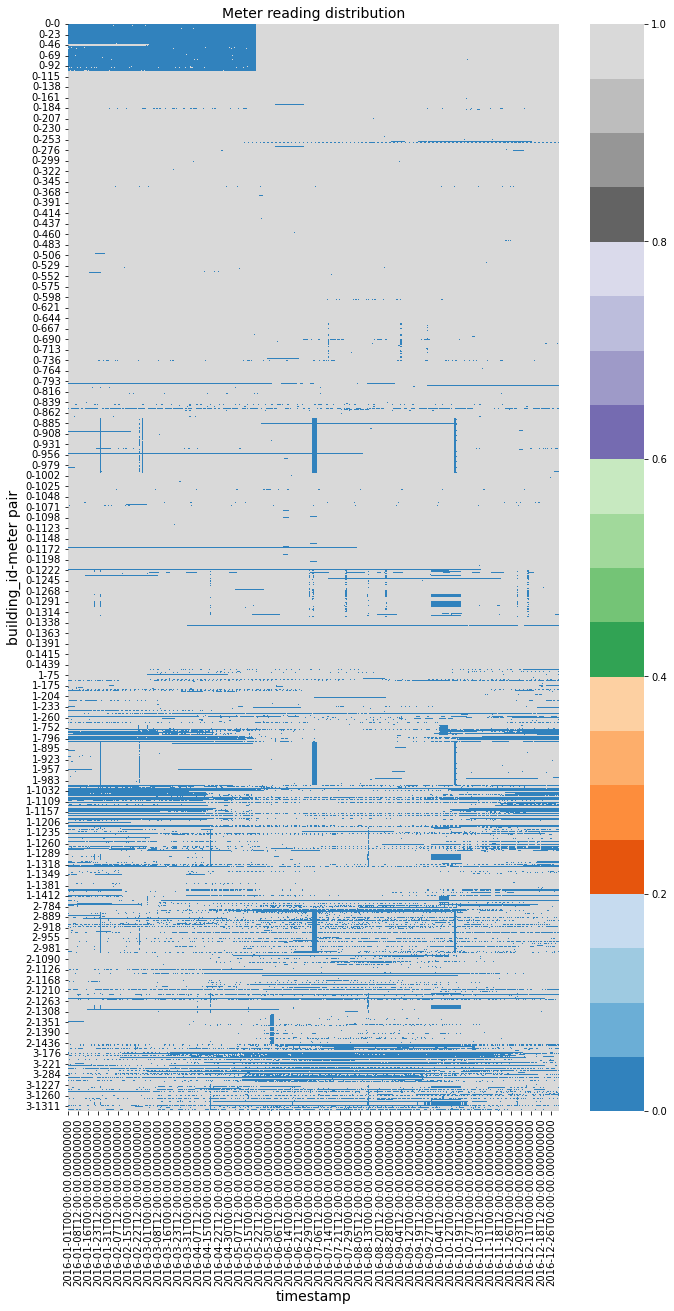

In [ ]:
#visualize zero reading distribution
plt.figure(figsize=(11,20))
sns.heatmap((temp!=0).astype('int8'), cmap='tab20c')
plt.title("Meter reading distribution", fontsize=14)
plt.xlabel('timestamp', fontsize=14)
plt.ylabel('building_id-meter pair', fontsize=14)
plt.show()

About Graph:
- Y axis represent building-meter pair (2380 pairs)
- X axis represent timestamp (hourly reading for 2016)
- Blue color represent zero reading
- Grey color represent non-zero reading
Observation:
- Thick blue patch on left top corner of graph:
    - It represent electrical reading for site 0 buildings.
    - Ranges approximately for first 5 months
    - Since all building belong to site 0, reason for this type of reading maybe associated with the site
- Meter 1 reading (Cold Water):
    - We can clearly observe seasonal pattern in meter 1 reading
    - There are more zero readings in core winter months (start and end of year)
- Meter 2 amd Meter 3 (Hot water and Steam):
    - Similarly like meter 1, meter 2 and 3 also shows seasonality
    - There are more zero readings in core summer months (middle of the year)
- Verical patches:
    - There are some vertical blue patches across different meter type for given range of timestamp. This can be attributed to site level pattern.
- Anomaly Vs Seasonality:
    - Pattern visible across different meter type belonging to same site can be marked as anomaly
    - Pattern visible across different site id for same meter type can be treated as seasonality

In [ ]:
x = (temp==0).sum(axis=1)/8784
for i in range(0,101, 10):
    print(f"Number of building-meter pair having zero readings >= {i:3}%: ", (x.loc[3, :]*100>=i).sum())

Number of building-meter pair having zero readings >=   0%:  145
Number of building-meter pair having zero readings >=  10%:  81
Number of building-meter pair having zero readings >=  20%:  62
Number of building-meter pair having zero readings >=  30%:  53
Number of building-meter pair having zero readings >=  40%:  37
Number of building-meter pair having zero readings >=  50%:  36
Number of building-meter pair having zero readings >=  60%:  27
Number of building-meter pair having zero readings >=  70%:  18
Number of building-meter pair having zero readings >=  80%:  10
Number of building-meter pair having zero readings >=  90%:  6
Number of building-meter pair having zero readings >= 100%:  0


In [ ]:
for i in range(0,101, 10):
    print(f"Number of building-meter pair having zero readings >= {i:3}%: ", (x.loc[0, :]*100>=i).sum())

Number of building-meter pair having zero readings >=   0%:  1413
Number of building-meter pair having zero readings >=  10%:  139
Number of building-meter pair having zero readings >=  20%:  129
Number of building-meter pair having zero readings >=  30%:  119
Number of building-meter pair having zero readings >=  40%:  17
Number of building-meter pair having zero readings >=  50%:  10
Number of building-meter pair having zero readings >=  60%:  6
Number of building-meter pair having zero readings >=  70%:  2
Number of building-meter pair having zero readings >=  80%:  1
Number of building-meter pair having zero readings >=  90%:  0
Number of building-meter pair having zero readings >= 100%:  0


In [ ]:
#meter reading distribution across site
temp.head()

timestamp          2016-01-01 00:00:00  2016-01-01 01:00:00  \
meter building_id                                             
0     0                            0.0                  0.0   
      1                            0.0                  0.0   
      2                            0.0                  0.0   
      3                            0.0                  0.0   
      4                            0.0                  0.0   

timestamp          2016-01-01 02:00:00  2016-01-01 03:00:00  \
meter building_id                                             
0     0                            0.0                  0.0   
      1                            0.0                  0.0   
      2                            0.0                  0.0   
      3                            0.0                  0.0   
      4                            0.0                  0.0   

timestamp          2016-01-01 04:00:00  2016-01-01 05:00:00  \
meter building_id                                             
0     0                            0.0                  0.0   
      1                            0.0                  0.0   
      2                            0.0                  0.0   
      3                            0.0                  0.0   
      4                            0.0                  0.0   

timestamp          2016-01-01 06:00:00  2016-01-01 07:00:00  \
meter building_id                                             
0     0                            0.0                  0.0   
      1                            0.0                  0.0   
      2                            0.0                  0.0   
      3                            0.0                  0.0   
      4                            0.0                  0.0   

timestamp          2016-01-01 08:00:00  2016-01-01 09:00:00  ...  \
meter building_id                                            ...   
0     0                            0.0                  0.0  ...   
      1                            0.0                  0.0  ...   
      2                            0.0                  0.0  ...   
      3                            0.0                  0.0  ...   
      4                            0.0                  0.0  ...   

timestamp          2016-12-31 14:00:00  2016-12-31 15:00:00  \
meter building_id                                             
0     0                     197.259995           188.386993   
      1                      89.551903           123.953003   
      2                       4.504900             5.733500   
      3                      81.565903            82.931099   
      4                    1136.459961          1125.540039   

timestamp          2016-12-31 16:00:00  2016-12-31 17:00:00  \
meter building_id                                             
0     0                     201.354996           176.783005   
      1                     111.121002            89.005798   
      2                       4.914400             4.504900   
      3                      87.026398            88.732803   
      4                    1105.750000          1152.160034   

timestamp          2016-12-31 18:00:00  2016-12-31 19:00:00  \
meter building_id                                             
0     0                     215.005997           232.070999   
      1                     138.695999            68.255997   
      2                       5.324000             4.914400   
      3                     102.384003           107.162003   
      4                    1146.020020          1150.800049   

timestamp          2016-12-31 20:00:00  2016-12-31 21:00:00  \
meter building_id                                             
0     0                     189.069000           169.957993   
      1                      52.420601            53.512699   
      2                       5.324000             5.733500   
      3                     107.162003           106.820999   
      4                    1197.890015          114

In [ ]:
train_df = train_df.merge(building_metadata_df[['site_id', 'primary_use', 'building_id']], on='building_id', how='left')
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use
0,0,0,2016-01-01,0.0,0,Education
1,1,0,2016-01-01,0.0,0,Education
2,2,0,2016-01-01,0.0,0,Education
3,3,0,2016-01-01,0.0,0,Education
4,4,0,2016-01-01,0.0,0,Education


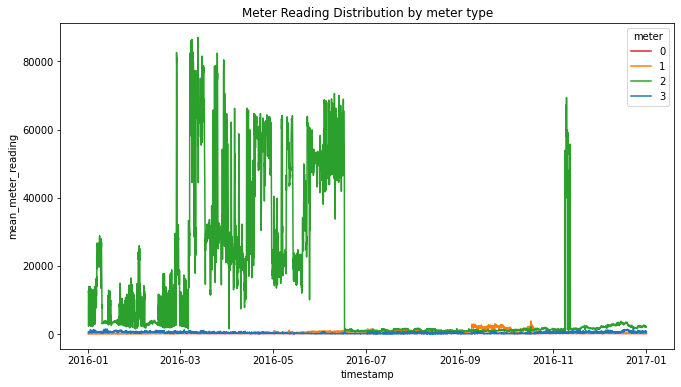

In [ ]:
plt.figure(figsize=(11,6))
sns.lineplot(data=train_df.groupby(['meter', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='meter', x='timestamp', y='mean_meter_reading', palette=['tab:red', 'tab:orange', 'tab:green', 'tab:blue'])
plt.title("Meter Reading Distribution by meter type")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent mean meter reading across different meter type at a given timestamp

> Observation:
- Meter 2 reading are absurdly high compared to other meter type

> Action:
- We will further analyse meter 2 reading and find the root cause behind such high value readings

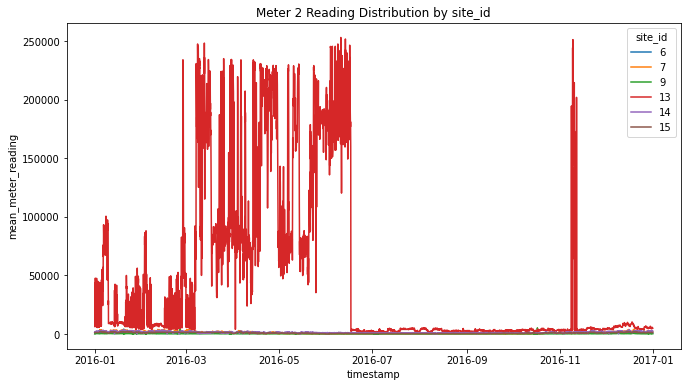

In [ ]:
plt.figure(figsize=(11,6))
sns.lineplot(data=train_df[train_df.meter==2].groupby(['site_id', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='site_id', x='timestamp', y='mean_meter_reading', palette='tab20c')
plt.title("Meter 2 Reading Distribution by site_id")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent mean meter 2 reading across different site_id at a given timestamp

> Observation:
- site_id 13 reading are absurdly high compared to other site_id

> Action:
- We will further analyse site_id 13 reading and find the root cause behind such high value readings

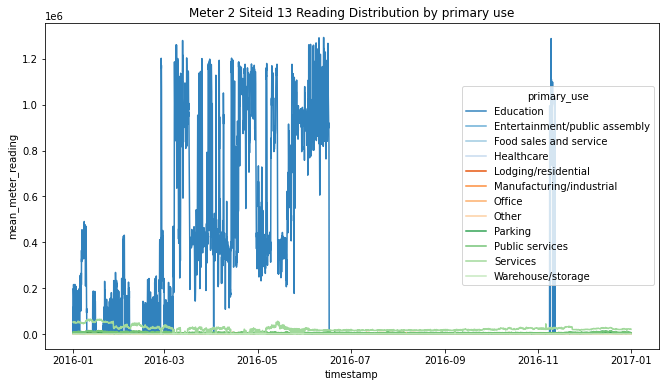

In [ ]:
plt.figure(figsize=(11,6))
condition = (train_df.meter==2) & (train_df.site_id==13)
sns.lineplot(data=train_df[condition].groupby(['primary_use', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='primary_use', x='timestamp', y='mean_meter_reading', palette='tab20c')
plt.title("Meter 2 Siteid 13 Reading Distribution by primary use")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent mean meter 2 site_id 13 reading across different primary_use at a given timestamp

> Observation:
- Education sector readings are absurdly high compared to other primary_use

> Action:
- We will further analyse meter 2 reading of Education sector of site id 13 and find the root cause behind such high value readings

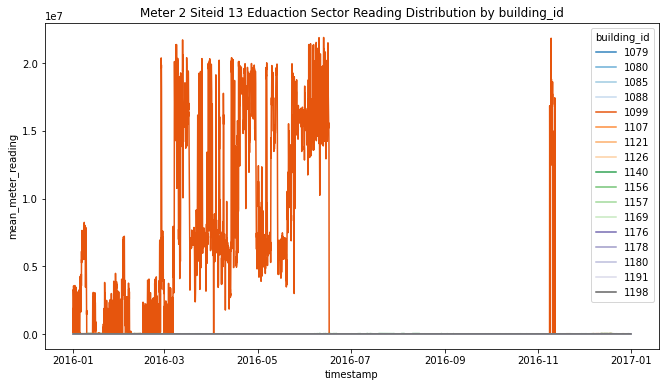

In [ ]:
plt.figure(figsize=(11,6))
condition = (train_df.meter==2) & (train_df.site_id==13) & (train_df.primary_use=='Education')
sns.lineplot(data=train_df[condition].groupby(['building_id', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='building_id', x='timestamp', y='mean_meter_reading', palette='tab20c')
plt.title("Meter 2 Siteid 13 Education Sector Reading Distribution by building_id")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent mean meter 2 site_id 13 Education sector reading across different building_id at a given timestamp

> Observation:
- building_id 1099 is responsible for such high readings

> Action:
- Including buildind_id 1099 in our train data will certainly effect performance of our model

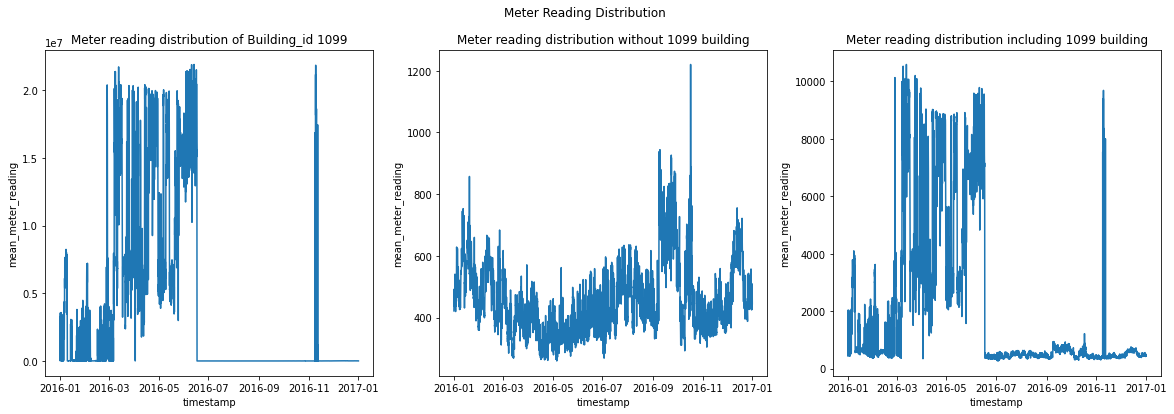

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,6))
condition_1 = (train_df['building_id'] == 1099) & (train_df['meter'] == 2)
condition_2 = train_df['building_id'] != 1099

sns.lineplot(data=train_df[condition_1].groupby(['timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             x='timestamp', y='mean_meter_reading', ax=axs[0])

sns.lineplot(data=train_df[condition_2].groupby(['timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             x='timestamp', y='mean_meter_reading', ax=axs[1])

sns.lineplot(data=train_df.groupby(['timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             x='timestamp', y='mean_meter_reading', ax=axs[2])

axs[0].set_title("Meter reading distribution of Building_id 1099")
axs[1].set_title("Meter reading distribution without 1099 building")
axs[2].set_title("Meter reading distribution including 1099 building")
plt.suptitle("Meter Reading Distribution")

plt.show()

> About graph:
- Graph 1: building_id 1099 meter reading distribution
- Graph 2: meter reading distribution without including 1099 building
- Graph 3: meter reading distribution including 1099 building

> Observation:
- Graph 1 and Graph 3 represent same pattern. This concludes that entire meter distribution was mainly influenced by building 1099

> Action:
- Including buildind_id 1099 in our train data will certainly effect performance of our model

In [ ]:
train_df = train_df[train_df.building_id != 1099]

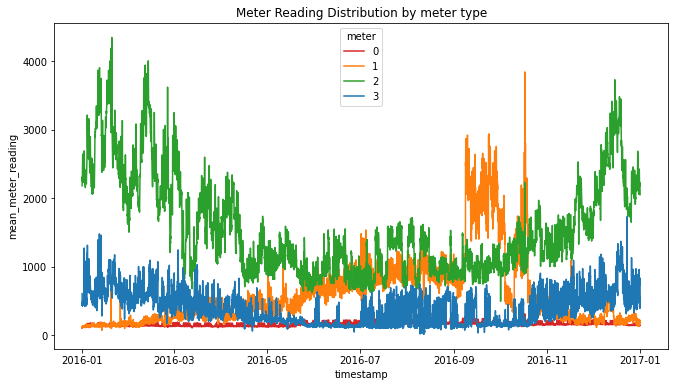

In [ ]:
plt.figure(figsize=(11,6))
sns.lineplot(data=train_df.groupby(['meter', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='meter', x='timestamp', y='mean_meter_reading', palette=['tab:red', 'tab:orange', 'tab:green', 'tab:blue'])
plt.title("Meter Reading Distribution by meter type")
plt.show()

> Preprocessing:
- We have removed building id 1099 from our data
- We will analyse further with this data

> About graph:
- X axis represent timestamp
- Y axis represent meter reading for different meter type

> Observation:
- Meter reading distribution changes significantly with meter type
- We can observe dip in meter 2 and meter 3 reading in core summer months
- We can also observe rise in meter 1 reading in core summer months
- Also there is a sudden spike in meter 1 reading starting at month 9

> Action:
- We need to analyse each meter type separately

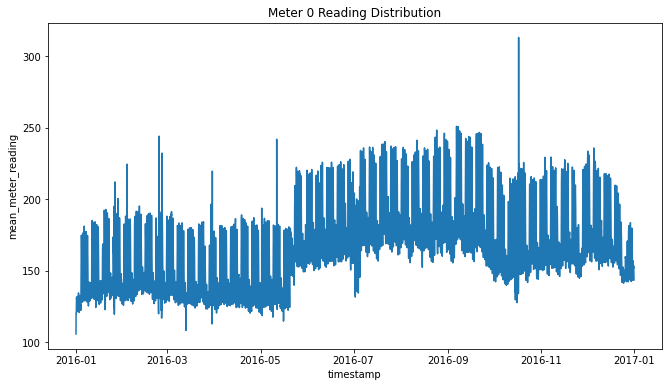

In [ ]:
# Meter 0
plt.figure(figsize=(11,6))
condition = (train_df.meter==0)
sns.lineplot(data=train_df[condition].groupby(['timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             x='timestamp', y='mean_meter_reading', palette='tab20c')
plt.title("Meter 0 Reading Distribution")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent meter reading for meter type = 0 (Electrical Reading)

> Observation:
- We can observe drift in meter reading distribution after middle of month 5 (approximately)

> Action:
- We will further analyse different site_id and see if this drift is common across different site_id

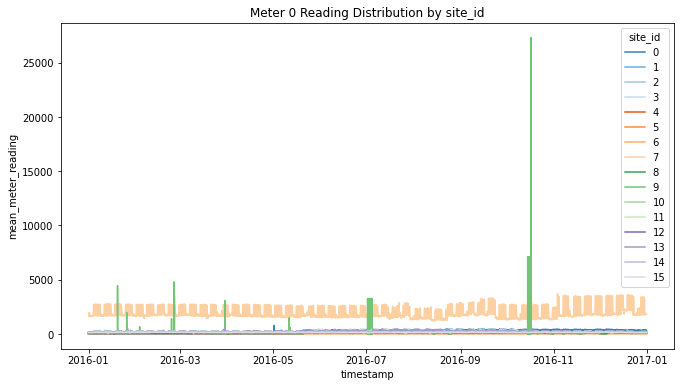

In [ ]:
plt.figure(figsize=(11,6))
condition = (train_df.meter==0)
sns.lineplot(data=train_df[condition].groupby(['site_id', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='site_id', x='timestamp', y='mean_meter_reading', palette='tab20c')
plt.title("Meter 0 Reading Distribution by site_id")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent meter reading for meter type = 0 (Electrical Reading) by site_id

> Observation:
- site_id 7 meter reading are different from rest of the site_id
- we can observe green spikes corresponding to site_id 9 (anamoly)

> Action:
- we will analyse meter=0 reading without site_id 7
- we will analyse meter=0 reading exclusively with site_id 7

In [ ]:
train_df = train_df.assign(day=train_df.timestamp.dt.day,
                           month = train_df.timestamp.dt.month,
                           dayofweek=train_df.timestamp.dt.dayofweek)

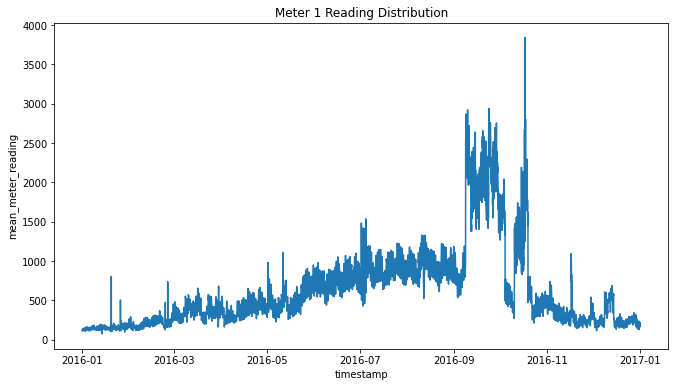

In [ ]:
# Meter 1
plt.figure(figsize=(11,6))
condition = (train_df.meter==1)
sns.lineplot(data=train_df[condition].groupby(['timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             x='timestamp', y='mean_meter_reading', palette='tab20c')
plt.title("Meter 1 Reading Distribution")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent meter reading for meter type = 0 (Electrical Reading)

> Observation:
- we can observe sudden spike in the month of october

> Action:
- we will further analyse for this spike

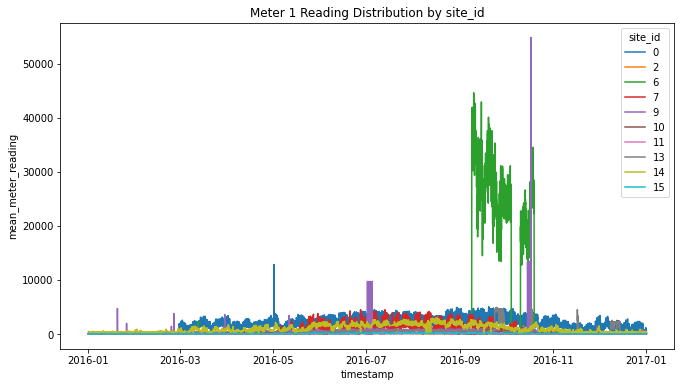

In [ ]:
# Meter 1 by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==1)
sns.lineplot(data=train_df[condition].groupby(['site_id', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='site_id', x='timestamp', y='mean_meter_reading', palette='tab10')
plt.title("Meter 1 Reading Distribution by site_id")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent meter reading by site_id where meter type=0

> Observation:
- site_id 6 and 9 are responsible for that spike

> Action:
- we will further analyse for this site_id 6 and 9

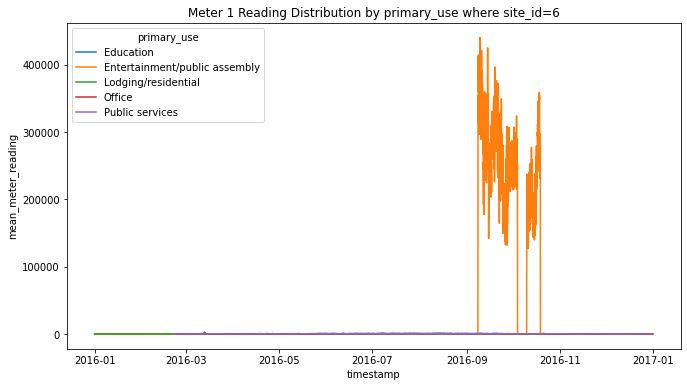

In [ ]:
# Meter 1 by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==1) & (train_df.site_id==6)
sns.lineplot(data=train_df[condition].groupby(['primary_use', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='primary_use', x='timestamp', y='mean_meter_reading', palette='tab10')
plt.title("Meter 1 Reading Distribution by primary_use where site_id=6")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent meter reading by primary_use where site_id=6

> Observation:
- primary_use='Entertainment/public assembly' is responsible for the sudden spike

> Action:
- we will further analyse primary_use='Entertainment/public assembly'

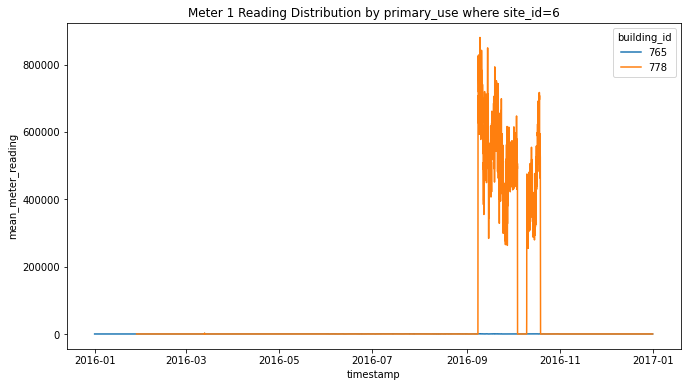

In [ ]:
# Meter 1 by building_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==1) & (train_df.site_id==6) & (train_df.primary_use=='Entertainment/public assembly')
sns.lineplot(data=train_df[condition].groupby(['building_id', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='building_id', x='timestamp', y='mean_meter_reading', palette='tab10')
plt.title("Meter 1 Reading Distribution by primary_use where site_id=6")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent meter reading by building_id where meter=1, site_id=6, primary_sector='Entertainment/public assembly'

> Observation:
- building_id 778 is responsible for that spike
- we also observed that 778 was active only in those timestamp and remaining all readings are 0

> Action:
- we would not include 778 in our train data

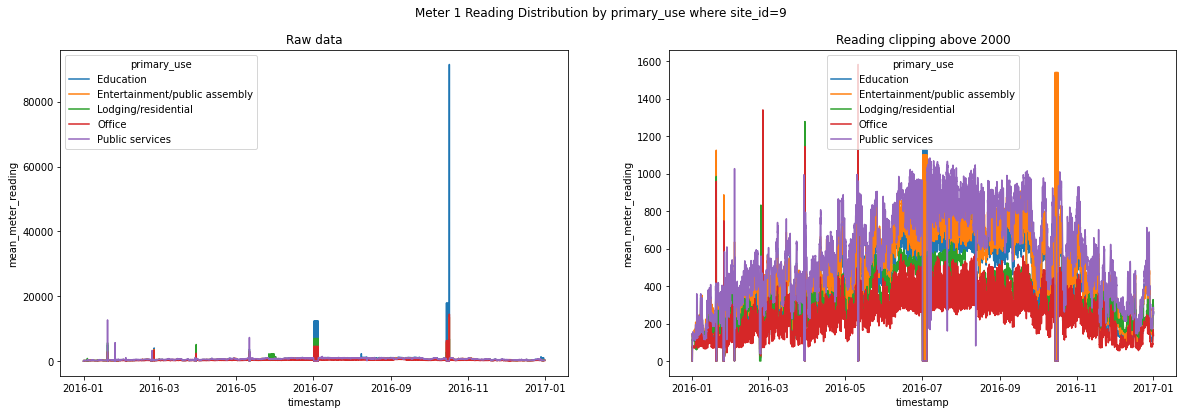

In [ ]:
# Meter 1 by primary_use where site_id=9
fig, axs = plt.subplots(1,2,figsize=(20,6))
condition_1 = (train_df.meter==1) & (train_df.site_id==9) #without clip
condition_2 = (train_df.meter==1) & (train_df.site_id==9) & (train_df.meter_reading<2000) #clipping values below 2000
sns.lineplot(data=train_df[condition_1].groupby(['primary_use', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='primary_use', x='timestamp', y='mean_meter_reading', palette='tab10', ax=axs[0])
sns.lineplot(data=train_df[condition_2].groupby(['primary_use', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='primary_use', x='timestamp', y='mean_meter_reading', palette='tab10', ax=axs[1])
axs[0].set_title("Raw data")
axs[1].set_title("Reading clipping above 2000")

plt.suptitle("Meter 1 Reading Distribution by primary_use where site_id=9")
plt.show()

> About graph:
- X axis represent timestamp
- Y axis represent meter reading by primary_use where meter=1, site_id=9

> Observation:
- we observed huge spike at different timestamp
- after clipping value above 2000 we can observe clear pattern in the readings

> Action:
- reading clipped above 2000

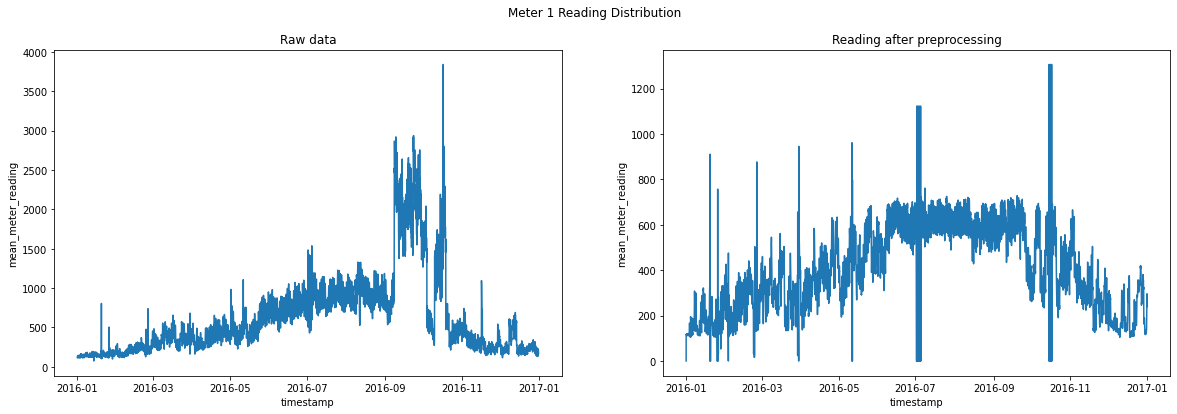

In [ ]:
# Meter 1 by primary_use where site_id=9
fig, axs = plt.subplots(1,2,figsize=(20,6))
condition_0 = (train_df.meter==1)
condition_1 = (train_df.meter==1) & (train_df.building_id!=778) #remove 778
condition_2 = (train_df.meter==1) & (train_df.site_id==9) & (train_df.meter_reading<2000) #clipping values below 2000 for site 9
sns.lineplot(data=train_df[condition_0].groupby(['timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             x='timestamp', y='mean_meter_reading', palette='tab10', ax=axs[0])
sns.lineplot(data=train_df[(condition_1 & condition_2)].groupby(['timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             x='timestamp', y='mean_meter_reading', palette='tab10', ax=axs[1])
axs[0].set_title("Raw data")
axs[1].set_title("Reading after preprocessing")

plt.suptitle("Meter 1 Reading Distribution")
plt.show()

Observation:
- Based on above observation we removed building 778 and clipped reading above 2000 for site_id = 9
- We can clearly observe the difference

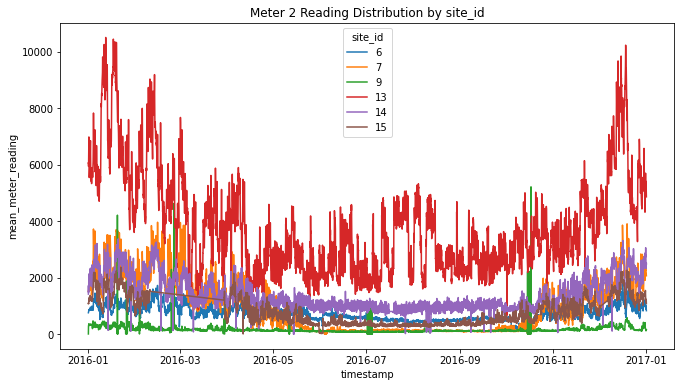

In [ ]:
# Meter 2 by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==2)
sns.lineplot(data=train_df[condition].groupby(['site_id', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='site_id', x='timestamp', y='mean_meter_reading', palette='tab10')
plt.title("Meter 2 Reading Distribution by site_id")
plt.show()

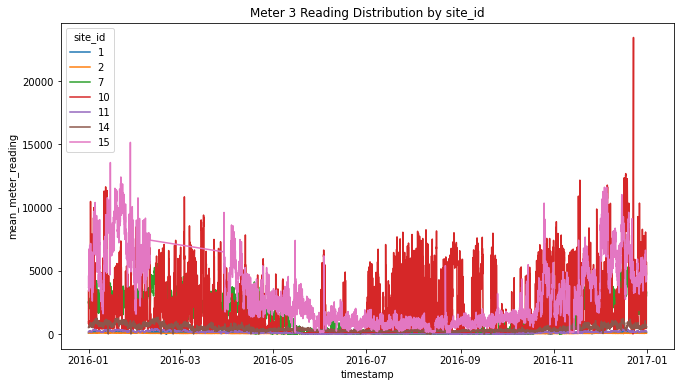

In [ ]:
# Meter 3 by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==3)
sns.lineplot(data=train_df[condition].groupby(['site_id', 'timestamp']).agg(mean_meter_reading=('meter_reading', 'mean')).reset_index(),
             hue='site_id', x='timestamp', y='mean_meter_reading', palette='tab10')
plt.title("Meter 3 Reading Distribution by site_id")
plt.show()

Observation:
- For meter 2 and 3 we do not observe major abnormality

In [ ]:
train_df = train_df.assign(hour=train_df.timestamp.dt.hour,
                            day=train_df.timestamp.dt.day,
                            dayofweek=train_df.timestamp.dt.dayofweek,
                            month=train_df.timestamp.dt.month)
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,hour,day,dayofweek,month
0,0,0,2016-01-01,0.0,0,Education,0,1,4,1
1,1,0,2016-01-01,0.0,0,Education,0,1,4,1
2,2,0,2016-01-01,0.0,0,Education,0,1,4,1
3,3,0,2016-01-01,0.0,0,Education,0,1,4,1
4,4,0,2016-01-01,0.0,0,Education,0,1,4,1


In [ ]:
condition_1 = (train_df.building_id == 1099)
condition_2 = (train_df.meter == 1) & (train_df.building_id == 778)
condition_3 = (train_df.meter == 1) & (train_df.site_id == 9) & (train_df.meter_reading>2000)
train_df = train_df[~(condition_1|condition_2|condition_3)]

In [ ]:
def utility_plot(hue, operation, variable, scale, condition=None):
    n = len(scale)
    fig, axs = plt.subplots(n,1,figsize=(11,n*6))
    if condition is None:
        condition = [True]*train_df.shape[0]

    for i, attr in enumerate(scale):
        #{attr} mean
        sns.lineplot(data=train_df[condition].groupby([hue, attr]).agg(mean=(variable, operation)).reset_index(),
                    x=attr, y='mean', hue=hue, palette='tab20', ax=axs[i])
        axs[i].set_ylabel(operation)
        axs[i].set_xlabel(attr)
        axs[i].legend(loc=1)
        axs[i].set_title(f"{attr}({operation})-{variable} by {hue}")
    plt.show()

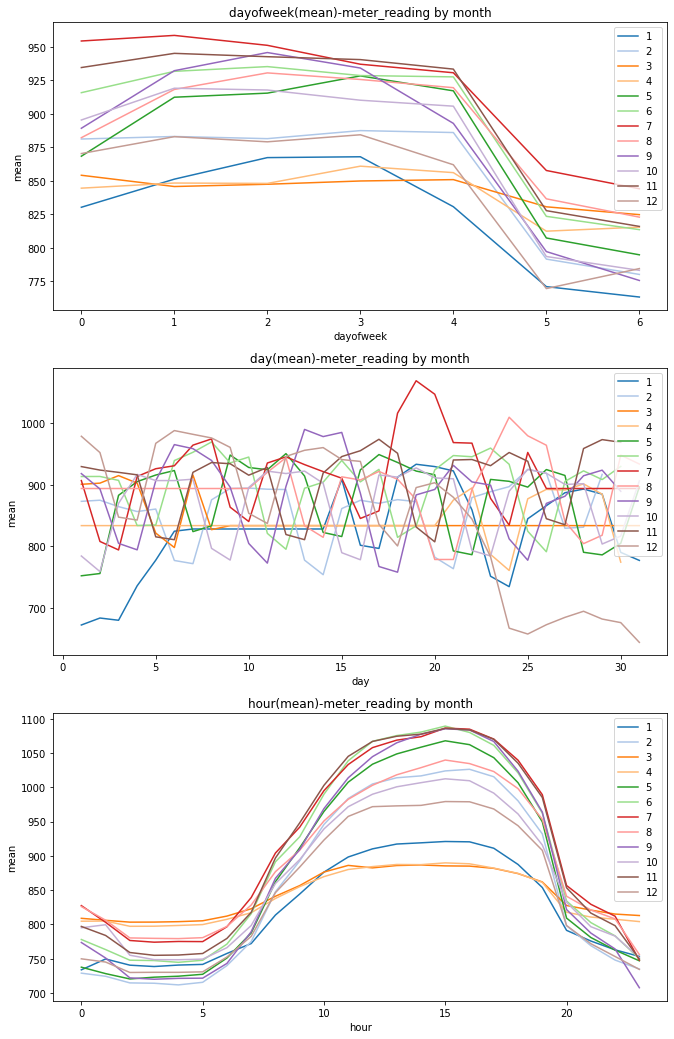

In [ ]:
condition = (train_df.meter==0) & (train_df.building_id==114)
hue='month'
operation = 'mean'
variable = 'meter_reading'
scale = ['dayofweek', 'day', 'hour']
utility_plot(hue, operation, variable, scale, condition)

Observation:
- Given a building id we can observe pattern in its hourly consumption across months
- Also we observe pattern in its week-day-based consumption

Action:
- We will incorporate these as features in our train data (week-day-mean, hour-mean)

# weather data

In [ ]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.0,NaN,1019.700012,0.0,0.0
1,0,2016-01-01 01:00:00,24.400000,NaN,21.1,-1.0,1020.200012,70.0,1.5
2,0,2016-01-01 02:00:00,22.799999,2.0,21.1,0.0,1020.200012,0.0,0.0
3,0,2016-01-01 03:00:00,21.100000,2.0,20.6,0.0,1020.099976,0.0,0.0
4,0,2016-01-01 04:00:00,20.000000,2.0,20.0,-1.0,1020.000000,250.0,2.6


In [ ]:
weather_train_df = weather_train_df.assign(month=weather_train_df.timestamp.dt.month,
                                           day=weather_train_df.timestamp.dt.day,
                                           hour=weather_train_df.timestamp.dt.hour)

## air_temperature

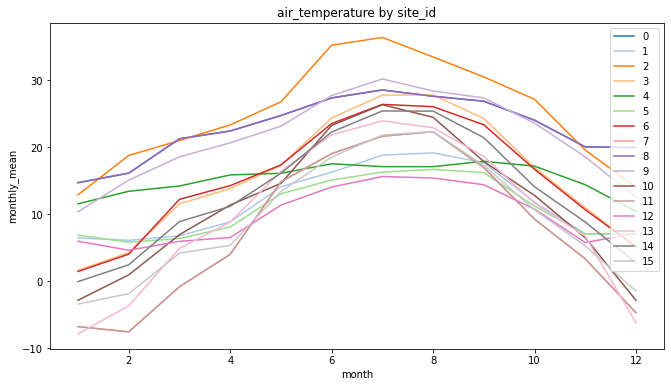

In [ ]:
# monthly mean air_temperature by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==3)
sns.lineplot(data=weather_train_df.groupby(['site_id', 'month']).agg(monthly_mean=('air_temperature', 'mean')).reset_index(),
             hue='site_id', x='month', y='monthly_mean', palette='tab20')
plt.title("air_temperature by site_id")
plt.legend(loc=1)
plt.show()

Observation:
- Data is sensible as temperature rises in peak summer months and again decreases at start and end of year


In [ ]:
offsets = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

In [ ]:
data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('air_temperature', 'mean')).reset_index()
for site_id, offset in enumerate(offsets):
    data.loc[(data['site_id'] == site_id), 'hour'] = (data.loc[(data['site_id'] == site_id), 'hour'] + offset)%24

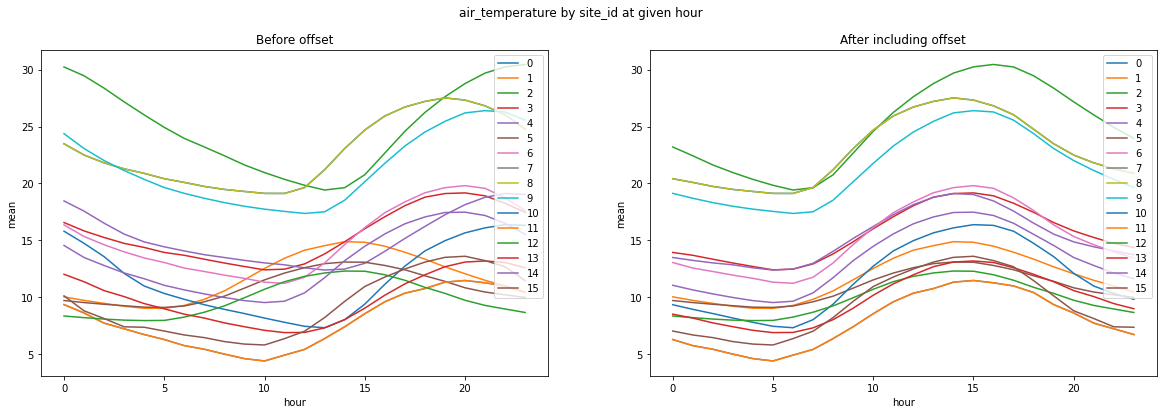

In [ ]:
# hourly mean air_temperature by site_id
fig, axs = plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('air_temperature', 'mean')).reset_index(),
             hue='site_id', x='hour', y='mean', palette='tab20', ax=axs[0])
sns.lineplot(data=data,
             hue='site_id', x='hour', y='mean', palette='tab20', ax=axs[1])
axs[0].set_title("Before offset")
axs[1].set_title("After including offset")
plt.suptitle("air_temperature by site_id at given hour")
axs[0].legend(loc=1)
axs[1].legend(loc=1)
plt.show()

In [ ]:
data=weather_train_df.groupby(['site_id', 'month', 'hour']).agg(mean=('air_temperature', 'mean')).reset_index()
for site_id, offset in enumerate(offsets):
    data.loc[(data['site_id'] == site_id), 'hour'] = (data.loc[(data['site_id'] == site_id), 'hour'] + offset)%24

data=data.groupby(['month', 'hour']).agg(mean=('mean', 'mean')).reset_index()

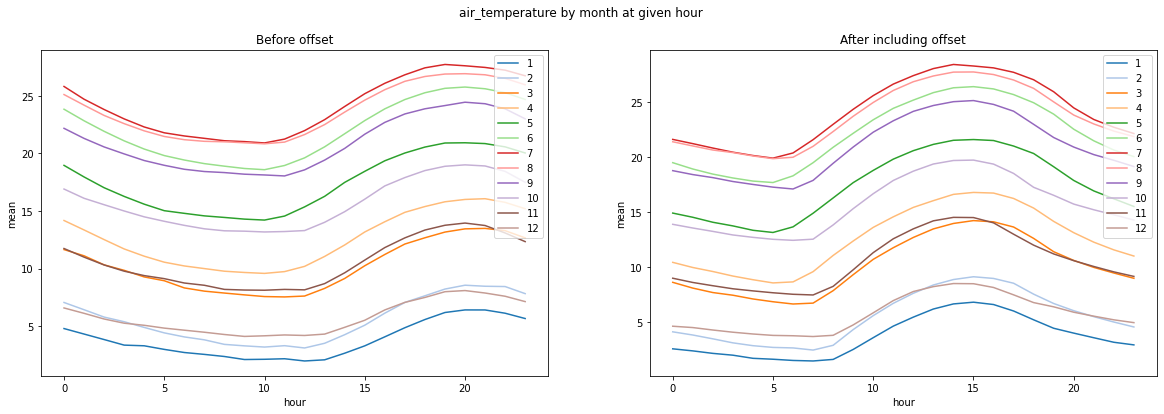

In [ ]:
# hourly mean air_temperature by month
fig, axs = plt.subplots(1,2,figsize=(20,6))
condition = (train_df.meter==3)
sns.lineplot(data=weather_train_df.groupby(['month', 'hour']).agg(mean=('air_temperature', 'mean')).reset_index(),
             hue='month', x='hour', y='mean', palette='tab20', ax=axs[0])
sns.lineplot(data=data,
             hue='month', x='hour', y='mean', palette='tab20', ax=axs[1])
axs[0].set_title("Before offset")
axs[1].set_title("After including offset")
plt.suptitle("air_temperature by month at given hour")
axs[0].legend(loc=1)
axs[1].legend(loc=1)
plt.show()

Observation:
- We can observe shift in pattern across site_id in graph 1
- After adding offset we can clearly observe hourly pattern across site in graph 2
- Also air_temperature shows both daily pattern and monthly pattern

## cloud_coverage

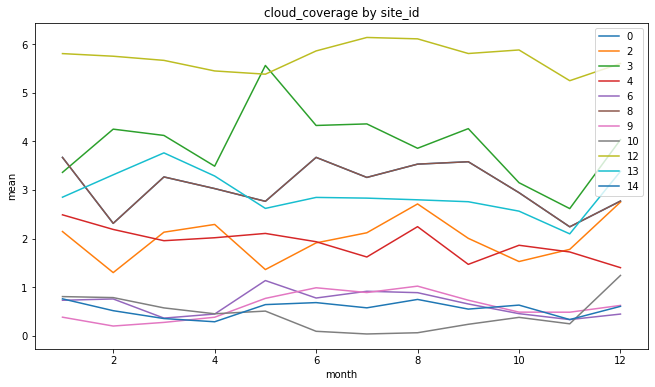

In [ ]:
# monthly mean cloud_coverage by site_id
plt.figure(figsize=(11,6))
condition = (weather_train_df.site_id.isin([0,2,3,4,6,8,9,10,12,13,14]))
sns.lineplot(data=weather_train_df[condition].groupby(['site_id', 'month']).agg(mean=('cloud_coverage', 'mean')).reset_index(),
             hue='site_id', x='month', y='mean', palette='tab10')
plt.title("cloud_coverage by site_id")
plt.legend(loc=1)
plt.show()

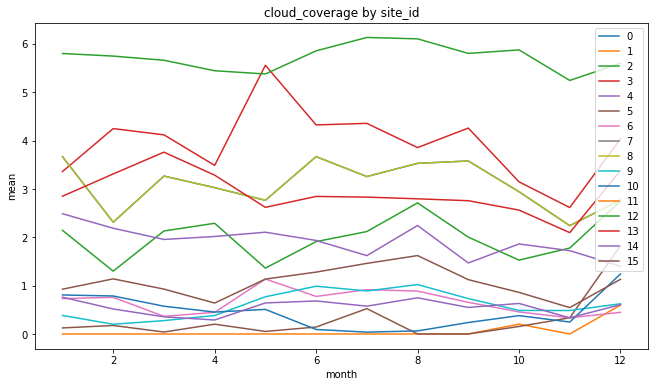

In [ ]:
# monthly mean cloud_coverage by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==3)
sns.lineplot(data=weather_train_df.groupby(['site_id', 'month']).agg(mean=('cloud_coverage', 'mean')).reset_index(),
             hue='site_id', x='month', y='mean', palette='tab10')
plt.title("cloud_coverage by site_id")
plt.legend(loc=1)
plt.show()

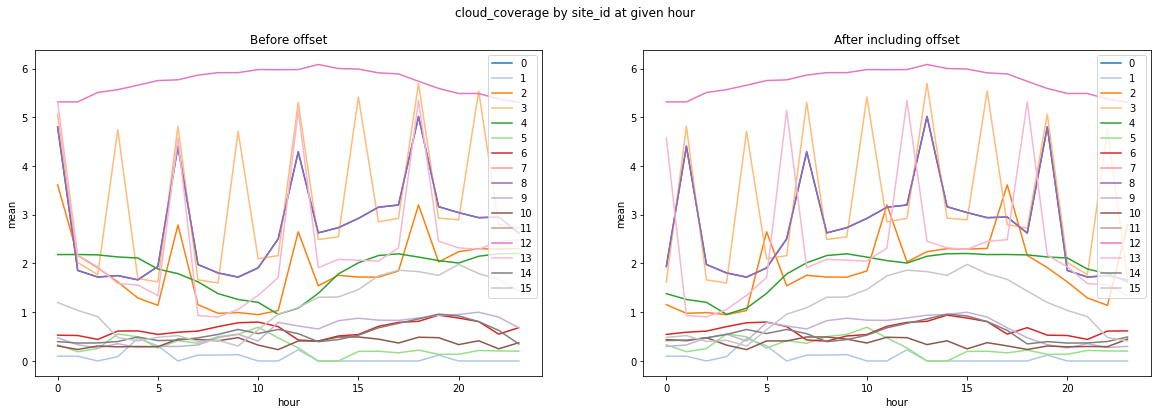

In [ ]:
# hourly mean cloud_coverage by site_id
data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('cloud_coverage', 'mean')).reset_index()
for site_id, offset in enumerate(offsets):
    data.loc[(data['site_id'] == site_id), 'hour'] = (data.loc[(data['site_id'] == site_id), 'hour'] + offset)%24

fig, axs = plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('cloud_coverage', 'mean')).reset_index(),
             hue='site_id', x='hour', y='mean', palette='tab20', ax=axs[0])
sns.lineplot(data=data,
             hue='site_id', x='hour', y='mean', palette='tab20', ax=axs[1])
axs[0].set_title("Before offset")
axs[1].set_title("After including offset")
plt.suptitle("cloud_coverage by site_id at given hour")
axs[0].legend(loc=1)
axs[1].legend(loc=1)
plt.show()

Observation:
- For cloud_coverage monthly pattern is not visible
- However we can clearly observe there is some daily pattern which it follows
- Also applying offset to cloud coverage disrupts the pattern
- We will observe further the impact of offset during modelling

## dew_temperature

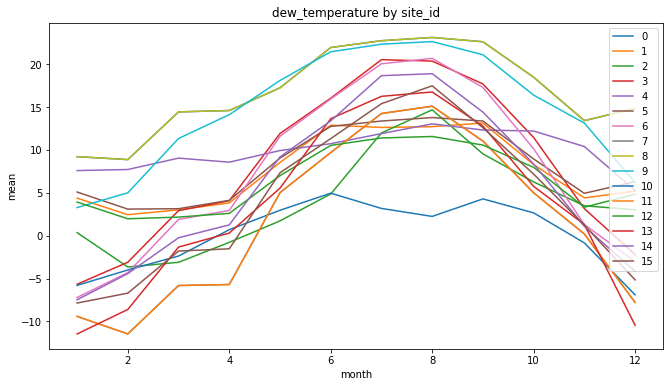

In [ ]:
# monthly mean dew_temperature by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==3)
sns.lineplot(data=weather_train_df.groupby(['site_id', 'month']).agg(mean=('dew_temperature', 'mean')).reset_index(),
             hue='site_id', x='month', y='mean', palette='tab10')
plt.title("dew_temperature by site_id")
plt.legend(loc=1)
plt.show()

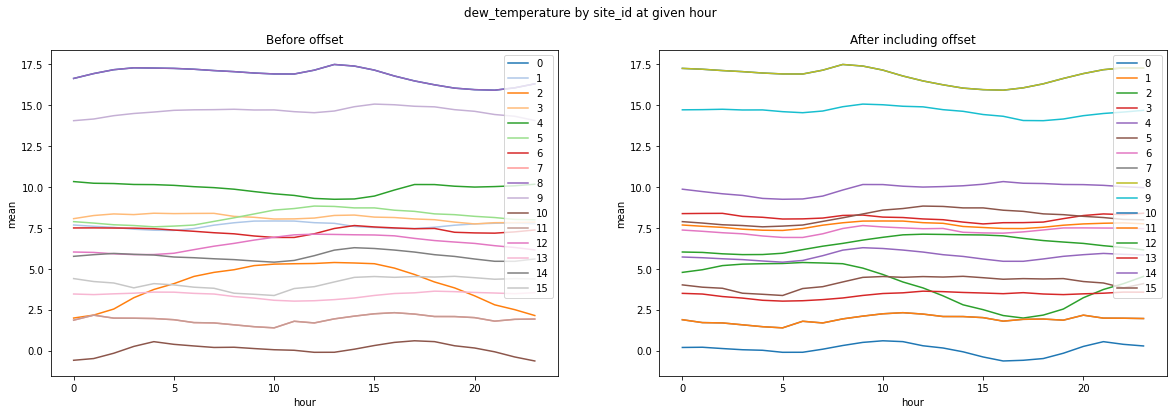

In [ ]:
data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('dew_temperature', 'mean')).reset_index()
for site_id, offset in enumerate(offsets):
    data.loc[(data['site_id'] == site_id), 'hour'] = (data.loc[(data['site_id'] == site_id), 'hour'] + offset)%24

# hourly mean dew_temperature by site_id
fig, axs = plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('dew_temperature', 'mean')).reset_index(),
             hue='site_id', x='hour', y='mean', palette='tab20', ax=axs[0])
sns.lineplot(data=data,
             hue='site_id', x='hour', y='mean', palette='tab10', ax=axs[1])
axs[0].set_title("Before offset")
axs[1].set_title("After including offset")
plt.suptitle("dew_temperature by site_id at given hour")
axs[0].legend(loc=1)
axs[1].legend(loc=1)
plt.show()

## precip_depth_1_hr

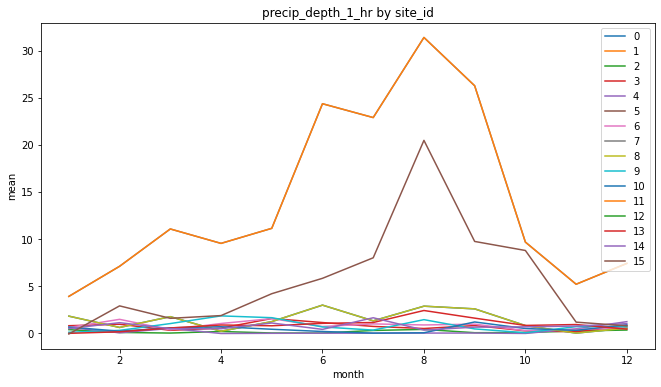

In [ ]:
# monthly mean precip_depth_1_hr by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==3)
sns.lineplot(data=weather_train_df.groupby(['site_id', 'month']).agg(mean=('precip_depth_1_hr', 'mean')).reset_index(),
             hue='site_id', x='month', y='mean', palette='tab10')
plt.title("precip_depth_1_hr by site_id")
plt.legend(loc=1)
plt.show()

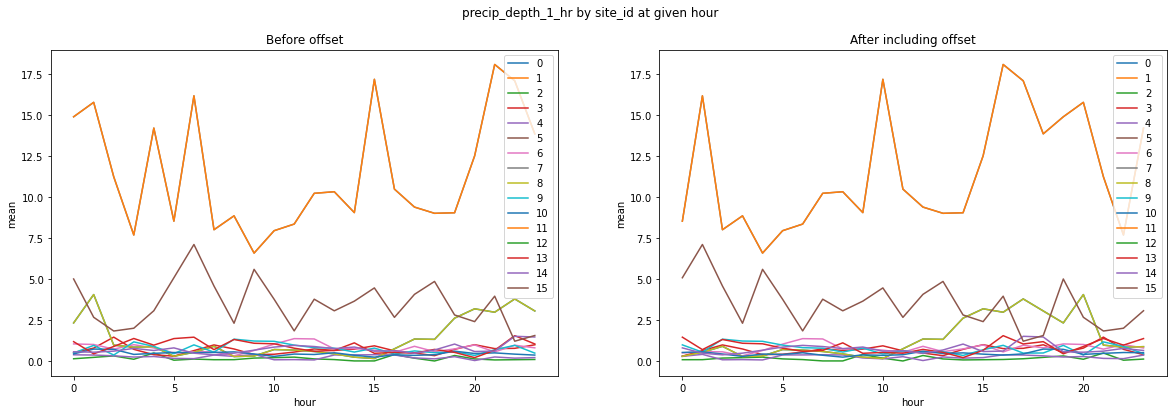

In [ ]:
data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('precip_depth_1_hr', 'mean')).reset_index()
for site_id, offset in enumerate(offsets):
    data.loc[(data['site_id'] == site_id), 'hour'] = (data.loc[(data['site_id'] == site_id), 'hour'] + offset)%24

# hourly mean precip_depth_1_hr by site_id
fig, axs = plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('precip_depth_1_hr', 'mean')).reset_index(),
             hue='site_id', x='hour', y='mean', palette='tab10', ax=axs[0])
sns.lineplot(data=data,
             hue='site_id', x='hour', y='mean', palette='tab10', ax=axs[1])
axs[0].set_title("Before offset")
axs[1].set_title("After including offset")
plt.suptitle("precip_depth_1_hr by site_id at given hour")
axs[0].legend(loc=1)
axs[1].legend(loc=1)
plt.show()

Observation:
- precip_depth_1_hr do not make much sense at both monthly and hourly level

## sea_level_pressure

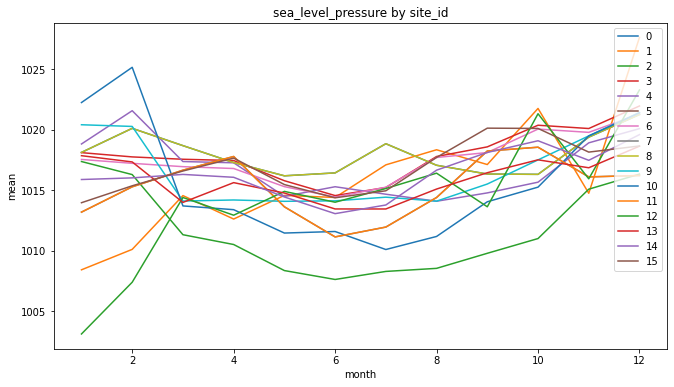

In [ ]:
# monthly mean sea_level_pressure by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==3)
sns.lineplot(data=weather_train_df.groupby(['site_id', 'month']).agg(mean=('sea_level_pressure', 'mean')).reset_index(),
             hue='site_id', x='month', y='mean', palette='tab10')
plt.title("sea_level_pressure by site_id")
plt.legend(loc=1)
plt.show()

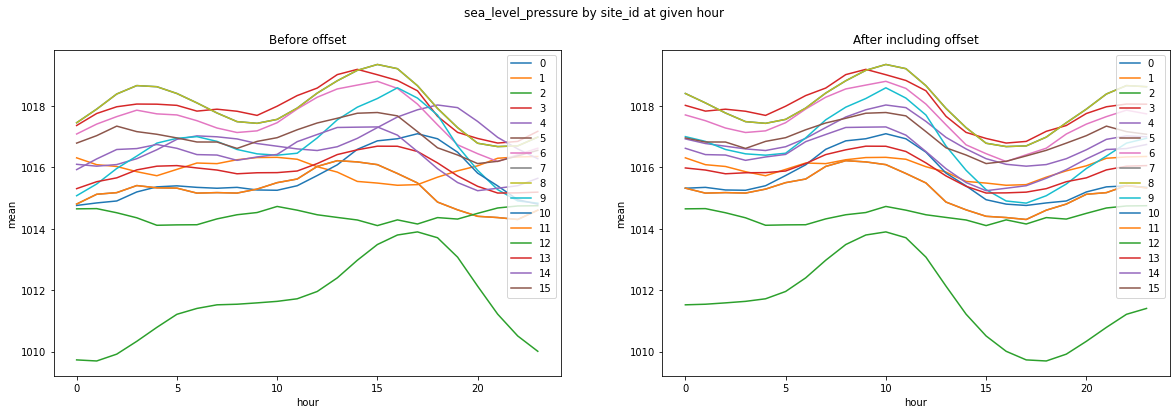

In [ ]:
data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('sea_level_pressure', 'mean')).reset_index()
for site_id, offset in enumerate(offsets):
    data.loc[(data['site_id'] == site_id), 'hour'] = (data.loc[(data['site_id'] == site_id), 'hour'] + offset)%24

# hourly mean sea_level_pressure by site_id
fig, axs = plt.subplots(1,2,figsize=(20,6))
sns.lineplot(data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('sea_level_pressure', 'mean')).reset_index(),
             hue='site_id', x='hour', y='mean', palette='tab10', ax=axs[0])
sns.lineplot(data=data,
             hue='site_id', x='hour', y='mean', palette='tab10', ax=axs[1])
axs[0].set_title("Before offset")
axs[1].set_title("After including offset")
plt.suptitle("sea_level_pressure by site_id at given hour")
axs[0].legend(loc=1)
axs[1].legend(loc=1)
plt.show()

Observation:
- On monthly level we see a minor dip in summer months
- On daily level we can clearly see some patterns after applying offset


## wind_speed

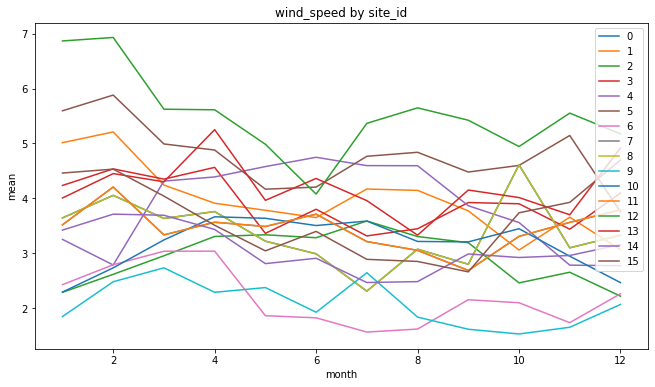

In [ ]:
# monthly mean wind_speed by site_id
plt.figure(figsize=(11,6))
condition = (train_df.meter==3)
sns.lineplot(data=weather_train_df.groupby(['site_id', 'month']).agg(mean=('wind_speed', 'mean')).reset_index(),
             hue='site_id', x='month', y='mean', palette='tab10')
plt.title("wind_speed by site_id")
plt.legend(loc=1)
plt.show()

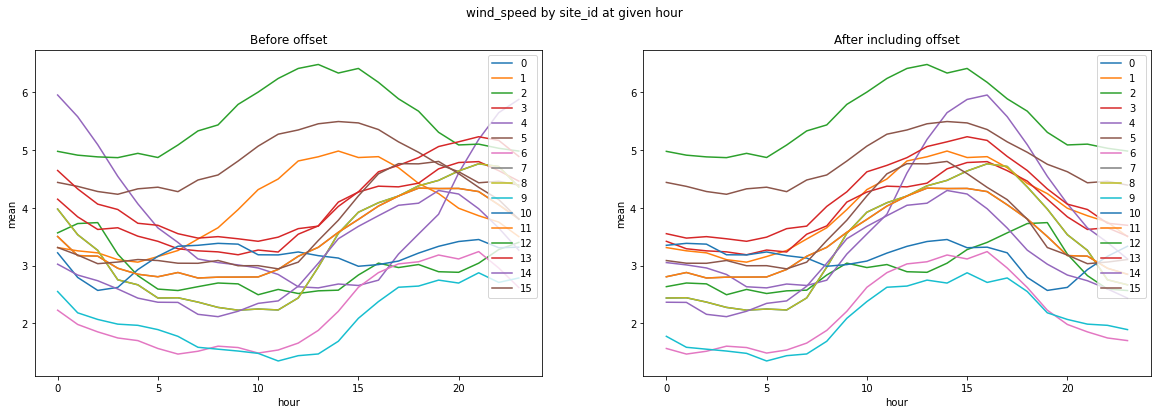

In [ ]:
data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('wind_speed', 'mean')).reset_index()
for site_id, offset in enumerate(offsets):
    data.loc[(data['site_id'] == site_id), 'hour'] = (data.loc[(data['site_id'] == site_id), 'hour'] + offset)%24

# hourly mean wind_speed by site_id
fig, axs = plt.subplots(1,2,figsize=(20,6))
condition = (train_df.meter==3)
sns.lineplot(data=weather_train_df.groupby(['site_id', 'hour']).agg(mean=('wind_speed', 'mean')).reset_index(),
             hue='site_id', x='hour', y='mean', palette='tab10', ax=axs[0])
sns.lineplot(data=data,
             hue='site_id', x='hour', y='mean', palette='tab10', ax=axs[1])
axs[0].set_title("Before offset")
axs[1].set_title("After including offset")
plt.suptitle("wind_speed by site_id at given hour")
axs[0].legend(loc=1)
axs[1].legend(loc=1)
plt.show()

Observation:
- On monthly pattern is not much visible
- However we can clearly observe pattern on daily scale after applying offset

# Final Thoughts:
> Building Data:
- year_built have more than 50% nan values (we will not include this feature in our model)
- floor_count have approximately 75% nan values
- we can impute floor_count as 0 (keeping remaining floor_count same) or 1 (increasing other floor_count values by 1)

> Meter Reading:
- meter = 0 (electrical reading)
    - We observed that building id 1099 have absurdly high values compare to all other buildings
    - site_id = 0 have 0 meter reading for approx 5 months
- meter = 1 (cold water reading)
    - Building 778 was also responsible was huge spike which was not common across site_id or building_id
    - site_id = 9 have abnormal values across different timestamp across different primary_use
    - we clipped site_id = 9 reading above 2000
    - we also observed seasonality across year with a dip in core winter months
- meter = 2 and 3 (hot water and steam):
    - no major abnormality observed
    - seasonality is visible across year with a clear dip in core summer months

> weather data:
- mainly air_temperature, dew_temperature and sea_level_pressure show seasonal impact
- we observed shift in timezone across different site_id (we were able to fix this applying simple offset)
